# SQL Agent

https://docs.langchain.com/oss/python/langchain/sql-agent

**SQL 에이전트의 동작 과정:**

1. 데이터베이스에서 사용 가능한 테이블과 스키마를 가져온다
2. 질문과 관련된 테이블을 결정한다
3. 관련 테이블의 스키마를 가져온다
4. 질문과 스키마 정보를 기반으로 쿼리를 생성한다
5. LLM을 사용하여 일반적인 실수가 있는지 쿼리를 재확인한다
6. 쿼리를 실행하고 결과를 반환한다
7. 쿼리가 성공할 때까지 데이터베이스 엔진에서 발생한 오류를 수정한다
8. 결과를 바탕으로 응답을 작성한다

**⚠️ 보안 경고:**

SQL 데이터베이스의 Q&A 시스템을 구축하려면 모델이 생성한 SQL 쿼리를 실행해야 한다. 이에는 내재된 위험이 있다. 데이터베이스 연결 권한이 항상 에이전트의 필요에 맞게 최대한 좁게 범위가 지정되어 있는지 확인해야 한다.

In [1]:
%pip install -Uq langchain langchain-openai langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")

## DB설정
sqlite기반의 Chinook.db 사용
- 디지털 미디어 스토어(음원/앨범) 예제 데이터베이스로, SQL 실습용으로 많이 쓰임
- 주요 테이블 예시: Artist, Album, Track, Genre, Playlist, Customer, Invoice, InvoiceLine
- 관계 구조(대략): Artist → Album → Track, Customer → Invoice → InvoiceLine(구매내역)
- 따라서 “아티스트/앨범/트랙 조회”, “고객별 구매액 집계”, “장르별 매출”, “인보이스(주문) 분석” 같은 쿼리 연습에 적합

In [ ]:
import requests
import pathlib

# Chinook 데이터베이스 다운로드
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
local_path = pathlib.Path("Chinook.db")

if local_path.exists():
    print(f"{local_path} 파일이 이미 존재한다. 다운로드를 건너뜀.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        local_path.write_bytes(response.content)  # 응답 바이트를 파일로 저장
        print(f"파일이 다운로드되어 {local_path}로 저장됨.")
    else:
        print(f"파일 다운로드에 실패. 상태 코드: {response.status_code}")

파일이 다운로드되어 Chinook.db로 저장됨.


## DB 연결

In [ ]:
from langchain_community.utilities import SQLDatabase  # DB연결 및 SQL 실행 유틸리티

db = SQLDatabase.from_uri("sqlite:///Chinook.db")  # SQLite 파일(Chinook.db)로 DB 연결

print(f'DB: {db.dialect}') # dbms 종류
print(f'DB Tables: {db.get_usable_table_names()}')  # 사용 가능한 테이블 목록
print()

# SQL실행
results = db.run('select * from artist limit 5')
results

DB: sqlite
DB Tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']



"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]"

## DB 상호작용을 위한 도구모음

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_community.agent_toolkits import SQLDatabaseToolkit  # DB 기반 Tool 묶음 제공

llm = init_chat_model('openai:gpt-4.1-mini')
toolkit = SQLDatabaseToolkit(db=db, llm=llm)  # DB와 LLM을 연결해 SQL 툴킷 구성
tools = toolkit.get_tools()  # SQL 작업용 Tool 리스트 생성

for tool in tools:
    print(f'[{tool.name}]')
    print(tool.description)
    print()

c:\Users\Playdata\nlp\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[sql_db_query]
Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

[sql_db_schema]
Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

[sql_db_list_tables]
Input is an empty string, output is a comma-separated list of tables in the database.

[sql_db_query_checker]
Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



## Agent 생성
- workflow: StateGraph객체 기반으로 노드/엣지 설정. 흐름 명시
- agent: create_agent로 생성된 객체. llm/tools을 가지고, 툴선택/실행까지 직접 처리

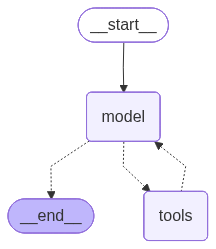

In [ ]:
from langchain.agents import create_agent

system_prompt = """
당신은 SQL 데이터베이스와 상호작용하도록 설계된 에이전트이다.
입력 질문이 주어지면 문법적으로 올바른 실행가능한 {dialect} 쿼리를 생성한 다음 쿼리 결과를 보고 답변을 반환한다.
사용자가 특정 개수의 레코드를 얻고자 하는 경우를 제외하고는 항상 쿼리를 최대 {top_k}개의 결과로 제한한다.

관련 열을 기준으로 결과를 정렬하여 데이터베이스에서 가장 흥미로운 레코드를 반환할 수 있다.
특정 테이블의 모든 열을 쿼리하지 말고 질문과 관련된 열만 요청한다.

쿼리를 실행하기 전에 반드시 쿼리를 재확인해야 한다.
쿼리를 실행하는 동안 오류가 발생하면 쿼리를 다시 작성하고 재시도한다.

**데이터베이스에 대한 DML 문(INSERT, UPDATE, DELETE, DROP 등)을 작성하지 않는다.**

시작할 때는 항상 데이터베이스의 테이블을 확인하여 쿼리할 수 있는 내용을 확인해야 한다.
이 단계를 건너뛰지 않는다.

그런 다음 가장 관련성이 높은 테이블의 스키마를 쿼리해야 한다.
""".format(dialect=db.dialect, top_k=5)  # DB 쿼리/조회 제한 개수 프롬프트에 주입

# LLM + SQL Tools + system_prompt로 에이전트 생성
agent = create_agent(
    llm,
    tools,
    system_prompt=system_prompt
)
agent

## Agent 실행

In [12]:
question = '최신 앨범/아티스트를 조회해줘'

print(f'Question: {question}')

# 에이전트를 스트리밍 모드로 실행
for step in agent.stream({
    'messages': [('human', question)]
}, stream_mode='values'):                # 중간 단계 메시지를 확인
    step['messages'][-1].pretty_print()  # 각 단계에서 생성된 마지막 메시지를 보기 좋게 출력

Question: 최신 앨범/아티스트를 조회해줘
================================ Human Message =================================

최신 앨범/아티스트를 조회해줘
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_uFO5lTLmeLfGaHJo3hdQP6Oq)
 Call ID: call_uFO5lTLmeLfGaHJo3hdQP6Oq
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_iK1iPTiohitmIrHocNe9FMjW)
 Call ID: call_iK1iPTiohitmIrHocNe9FMjW
  Args:
    table_names: Album, Artist
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 

In [13]:
# question = '최우수 고객 3명이 누구야?'
# question = '가장 많은 앨범을 가진 아티스트는 누구야?'
# question = '국가별 고객수는 몇명이야?'
question = '가장 비싼 트랙 5개 보여줘'
# question = '평균적으로 가장 긴 트랙을 가지는 장르는 뭐야?'

print(f'Question: {question}')

for step in agent.stream({
    'messages': [('human', question)]
}, stream_mode='values'):
    step['messages'][-1].pretty_print()

Question: 가장 비싼 트랙 5개 보여줘
================================ Human Message =================================

가장 비싼 트랙 5개 보여줘
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_ZYFrut5CSKDGStwQSpbch1XE)
 Call ID: call_ZYFrut5CSKDGStwQSpbch1XE
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_NQ1CiHTyw5ON5TaAYngrM4kJ)
 Call ID: call_NQ1CiHTyw5ON5TaAYngrM4kJ
  Args:
    table_names: Track
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" IN

## Human-in-the-loop
- Middleware를 통한 HITL 구현

In [ ]:
from langchain.agents.middleware import HumanInTheLoopMiddleware  # 도구 실행 전 승인/중단 미들웨어
from langgraph.checkpoint.memory import InMemorySaver  # 실행 상태(체크포인트) 메모리 저장소

agent_with_hitl = create_agent(
    llm,
    tools,  # SQLDatabaseToolkit에서 생성된 Tool 리스트
    system_prompt=system_prompt,
    middleware=[  # 에이전트 실행 중 개입하는 미들웨어 추가
        HumanInTheLoopMiddleware(
            interrupt_on={'sql_db_query': True},  # sql_db_query 도구 실행 직전에 중단(승인 요청)
            description_prefix='[도구 실행 승인 대기중]'  # 중단시 안내 문구
        )
    ],
    checkpointer=InMemorySaver()  # 중단/재개 하기위해 상태를 메모리에 저장
)

In [ ]:
question = '평균적으로 가장 긴 트랙을 가지는 장르는 뭐야?'

print(f'Question: {question}')
config = {'configurable': {'thread_id': 1}}

for step in agent_with_hitl.stream({      # HITL 적용 에이전트를 스트리밍 실행
    'messages': [('human', question)]
}, stream_mode='values', config=config):
    if '__interrupt__' in step:  # 도구 실행 직전에 중단 이벤트가 발생한 경우
        print('에이젼트 실행이 중단되었습니다. 관리자의 승인을 기다리는 중...')

        interrupt = step['__interrupt__'][0]  # 발생한 interrupt 이벤트 1개 추출
        for request in interrupt.value['action_requests']:  # 승인 대기중인 도구 호출 요청들 순회
            print(f'도구: {request["name"]}')  # 실행하려는 도구 이름
            print(f'인자: {request["args"]}')  # 도구에 전달될 인자
            print(f'설명: {request["description"]}')  # 도구 설명
    elif 'messages' in step:  # 일반적인 메시지 업데이트가 되는 경우
        step['messages'][-1].pretty_print()  # 마지막 메시지 출력
    else:  # 그 외의 경우는 모두 무시
        pass

Question: 평균적으로 가장 긴 트랙을 가지는 장르는 뭐야?
================================ Human Message =================================

평균적으로 가장 긴 트랙을 가지는 장르는 뭐야?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_KByJxT0LilyihxSFRb0jpcor)
 Call ID: call_KByJxT0LilyihxSFRb0jpcor
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_QYShWe4PeCEbvZP9RYvauYU6)
 Call ID: call_QYShWe4PeCEbvZP9RYvauYU6
  Args:
    table_names: Genre, Track
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre

In [ ]:
# 관리자의 승인 처리
from langgraph.types import Command  # 중단된 실행을 재개하기 위한 Command 타입

# 도구 실행 요청을 승인(approve)하고 재개
command = Command(resume={'decisions': [{'type': 'approve'}]})

for step in agent_with_hitl.stream(command, stream_mode='values', config=config):
    if '__interrupt__' in step:
        print('에이젼트 실행이 중단되었습니다. 관리자의 승인을 기다리는 중...')

        interrupt = step['__interrupt__'][0]
        for request in interrupt.value['action_requests']:
            print(f'도구: {request["name"]}')
            print(f'인자: {request["args"]}')
            print(f'설명: {request["description"]}')
    elif 'messages' in step:
        step['messages'][-1].pretty_print()
    else:
        pass

================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_NZj3JMa8NMlnlpiLbO5Fp3Te)
 Call ID: call_NZj3JMa8NMlnlpiLbO5Fp3Te
  Args:
    query: SELECT Genre.Name, AVG(Track.Milliseconds) AS AvgMilliseconds FROM Track JOIN Genre ON Track.GenreId = Genre.GenreId GROUP BY Genre.Name ORDER BY AvgMilliseconds DESC LIMIT 5;
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_NZj3JMa8NMlnlpiLbO5Fp3Te)
 Call ID: call_NZj3JMa8NMlnlpiLbO5Fp3Te
  Args:
    query: SELECT Genre.Name, AVG(Track.Milliseconds) AS AvgMilliseconds FROM Track JOIN Genre ON Track.GenreId = Genre.GenreId GROUP BY Genre.Name ORDER BY AvgMilliseconds DESC LIMIT 5;
================================= Tool Message =================================
Name: sql_db_query

[('Sci Fi & Fantasy', 2911783.0384615385), ('Science Fiction', 2625549.076923077), ('Drama', 2575283.78125), ('TV Shows', 2145041.0215053763), ('Come